<a href="https://colab.research.google.com/github/Sukeshini22/Sukeshini22/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
from io import BytesIO
import PIL
import cv2
from skimage.transform import resize
import pandas as pd

# Define class names
class_names = ["Chocolate cyst", "High grade serous cystadenocarcinoma", "Mucinous cystadenoma",
               "Serous cystadenoma", "Simple cyst", "Teratoma", "Theca cell tumor"]

# Custom U-Net architecture for image segmentation
def create_segmentation_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D()(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D()(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D()(conv3)

    # Decoder
    up3 = UpSampling2D()(pool3)
    up3 = concatenate([conv3, up3], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up2 = UpSampling2D()(conv6)
    up2 = concatenate([conv2, up2], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up1 = UpSampling2D()(conv7)
    up1 = concatenate([conv1, up1], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    # Output
    output = Conv2D(1, 1, activation='sigmoid')(conv8)

    model = Model(inputs=inputs, outputs=output)
    return model


# Create a custom segmentation model
input_shape = (224, 224, 3)
segmentation_model = create_segmentation_model(input_shape)

# Get the encoder part of the segmentation model
encoder_model = Model(inputs=segmentation_model.input, outputs=segmentation_model.layers[6].output)  # Adjust the index based on the actual layer position

# Freeze the weights of the encoder so that they are not updated during training
for layer in encoder_model.layers:
    layer.trainable = False

# Classification model
flat = Flatten()(encoder_model.output)
dense1 = Dense(512, activation='relu')(flat)
output = Dense(len(class_names), activation='softmax')(dense1)

classification_model = Model(inputs=encoder_model.input, outputs=output)

# Compile the classification model
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the classification model
classification_model.summary()

# Define image data generators for training and validation
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/OvarianCancerDetection ',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',  # Use 'categorical' for classification
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/OvarianCancerDetection ',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='sparse',  # Use 'categorical' for classification
    subset='validation'
)

# Train the classification model
try:
    history_classification = classification_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator
    )
except Exception as e:
    print("Error during training:")
    print(e)

# Visualize training history for classification
if 'history_classification' in locals():
    plt.plot(history_classification.history['accuracy'], label='Training Accuracy')
    plt.plot(history_classification.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("Training history not available due to an error.")

    # Load the pre-trained classification model
classification_model = load_model('/content/drive/MyDrive/OvarianCancerDetection/class_model.h5')

# Define class names
class_names = ["Chocolate cyst", "High grade serous cystadenocarcinoma", "Mucinous cystadenoma",
               "Serous cystadenoma", "Simple cyst", "Teratoma", "Theca cell tumor"]

# Function to preprocess an image
def preprocess_image(img):
    img = img.resize((224, 224), Image.ANTIALIAS)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array
# Define GUI elements
file_upload = widgets.FileUpload(accept='image/*', multiple=False)
button_predict = widgets.Button(description='Predict')

# Output areas
output_image = widgets.Output()
output_prediction = widgets.Output()

# Define the U-Net segmentation model
input_shape = (224, 224, 3)
segmentation_model = create_segmentation_model(input_shape)

# Compile the segmentation model
segmentation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Event handlers
def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to match the model input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(_):
    # Check if a file is uploaded
    if not file_upload.value:
        with output_image:
            print("Please upload an image.")
        return

    # Load the uploaded image
    img_widget = file_upload.value[next(iter(file_upload.value))]
    img_bytes = img_widget['content']
    img = PIL.Image.open(BytesIO(img_bytes))

    # Preprocess the image for segmentation
    img_array = preprocess_image(img)

    # Predict segmentation result
    segmentation_result = segmentation_model.predict(img_array)

    # Resize original image to match the dimensions of the segmented result
    original_image_resized = resize(img_array.squeeze(), segmentation_result[0, :, :, 0].shape, anti_aliasing=True)

    # Apply Canny edge detection to the original image
    edges = cv2.Canny(img_array.squeeze().astype(np.uint8), 100, 200)

    # Apply segmentation mask to the original image
    segmented_image = original_image_resized * segmentation_result[0, :, :, 0][:, :, np.newaxis]

    # Normalize pixel values to the range [0, 1]
    segmented_image_normalized = segmented_image / np.max(segmented_image)

    # Predict class using the loaded classification model
    class_probabilities = classification_model.predict(img_array)
    predicted_class = np.argmax(class_probabilities)

    with output_image:
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title("Original Image")

        plt.subplot(1, 4, 2)
        plt.imshow(segmentation_result[0, :, :, 0], cmap='gray')
        plt.title("Segmentation")

        plt.subplot(1, 4, 3)
        plt.imshow(edges, cmap='gray')
        plt.title("Canny Edge Detection")

        plt.subplot(1, 4, 4)
        plt.imshow(segmented_image_normalized, cmap='viridis')  # Change the colormap as needed
        plt.title("Normalize")

        plt.show()

    with output_prediction:
        # Display predicted class
        print("Predicted Class:", class_names[predicted_class])

        # Create a table for class probabilities
        probabilities_table = pd.DataFrame(
            {'Class': class_names, 'Probability': class_probabilities.flatten() * 100}
        )
        print("\nClass Probabilities:")
        print(probabilities_table)


# Event handler for button click
button_predict.on_click(predict)

# Display GUI
display(widgets.VBox([file_upload, button_predict]))
display(output_image)
display(output_prediction)




Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                           

In [2]:


from tensorflow.keras.models import load_model

# Load the pre-trained model
model_path = '/content/drive/MyDrive/OvarianCancerDetection/class_model.h5'
classification_model = load_model(model_path)

1/1 [==============================] - 0s 310ms/step
Predicted Class: High grade serous cystadenocarcinoma


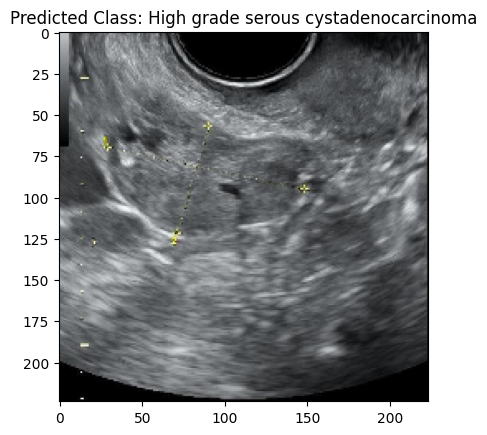

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Load and preprocess a test image
test_image_path = '/content/drive/MyDrive/OvarianCancerDetection /test/1432_JPG.rf.6dd54cdd172c6492049f708b9f0a9893.jpg'
test_image = image.load_img(test_image_path, target_size=(224, 224))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)
test_image_array = preprocess_input(test_image_array)
predictions = classification_model.predict(test_image_array)
predicted_class = np.argmax(predictions)
predicted_class_label = class_names[predicted_class]
print("Predicted Class:", predicted_class_label)
plt.imshow(test_image)
plt.title(f'Predicted Class: {predicted_class_label}')
plt.show()



In [ ]:
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
from io import BytesIO
import PIL
import cv2
from skimage.transform import resize
import pandas as pd

# Load the pre-trained classification model
classification_model = load_model('/content/drive/MyDrive/OvarianCancerDetection/class_model.h5')

# Define class names
class_names = ["Chocolate cyst", "High grade serous cystadenocarcinoma", "Mucinous cystadenoma",
               "Serous cystadenoma", "Simple cyst", "Teratoma", "Theca cell tumor"]

# Function to preprocess an image
def preprocess_image(img):
    img = img.resize((224, 224), Image.ANTIALIAS)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array
# Define GUI elements
file_upload = widgets.FileUpload(accept='image/*', multiple=False)
button_predict = widgets.Button(description='Predict')

# Output areas
output_image = widgets.Output()
output_prediction = widgets.Output()

# Define the U-Net segmentation model
input_shape = (224, 224, 3)
segmentation_model = create_segmentation_model(input_shape)

# Compile the segmentation model
segmentation_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Event handlers
def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to match the model input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict(_):
    # Check if a file is uploaded
    if not file_upload.value:
        with output_image:
            print("Please upload an image.")
        return

    # Load the uploaded image
    img_widget = file_upload.value[next(iter(file_upload.value))]
    img_bytes = img_widget['content']
    img = PIL.Image.open(BytesIO(img_bytes))

    # Preprocess the image for segmentation
    img_array = preprocess_image(img)

    # Predict segmentation result
    segmentation_result = segmentation_model.predict(img_array)

    # Resize original image to match the dimensions of the segmented result
    original_image_resized = resize(img_array.squeeze(), segmentation_result[0, :, :, 0].shape, anti_aliasing=True)

    # Apply Canny edge detection to the original image
    edges = cv2.Canny(img_array.squeeze().astype(np.uint8), 100, 200)

    # Apply segmentation mask to the original image
    segmented_image = original_image_resized * segmentation_result[0, :, :, 0][:, :, np.newaxis]

    # Normalize pixel values to the range [0, 1]
    segmented_image_normalized = segmented_image / np.max(segmented_image)

    # Predict class using the loaded classification model
    class_probabilities = classification_model.predict(img_array)
    predicted_class = np.argmax(class_probabilities)

    with output_image:
        plt.subplot(1, 4, 1)
        plt.imshow(img)
        plt.title("Original Image")

        plt.subplot(1, 4, 2)
        plt.imshow(segmentation_result[0, :, :, 0], cmap='gray')
        plt.title("Segmentation Result")

        plt.subplot(1, 4, 3)
        plt.imshow(edges, cmap='gray')
        plt.title("Canny Edge Detection")

        plt.subplot(1, 4, 4)
        plt.imshow(segmented_image_normalized, cmap='viridis')  # Change the colormap as needed
        plt.title("Normalize")

        plt.show()

    with output_prediction:
        # Display predicted class
        print("Predicted Class:", class_names[predicted_class])

        # Create a table for class probabilities
        probabilities_table = pd.DataFrame(
            {'Class': class_names, 'Probability': class_probabilities.flatten() * 100}
        )
        print("\nClass Probabilities:")
        print(probabilities_table)


# Event handler for button click
button_predict.on_click(predict)

# Display GUI
display(widgets.VBox([file_upload, button_predict]))
display(output_image)
display(output_prediction)
